# Imports

In [22]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import shapely

import networkx as nx
import osmnx as ox
from pprint import pprint

import pickle 

In [23]:
# color palette for visualizing walking/biking discomfort
chosen_cmap = sns.color_palette("Spectral", as_cmap = True)

# Read data

In [24]:
folder = "01_outputs/"

Gb_edges = gpd.read_file(folder + "geofabrik_bike_graph_edges_w_EDSAaccidents.geojson").set_index(["u", "v", "key"], drop = True)
Gb_nodes = gpd.read_file(folder + "geofabrik_bike_graph_nodes_w_brgycode_popdensity.geojson").set_index("osmid", drop = True)
Gw_edges = gpd.read_file(folder + "geofabrik_walk_graph_edges_w_EDSAaccidents.geojson").set_index(["u", "v", "key"], drop = True)
Gw_nodes = gpd.read_file(folder + "geofabrik_walk_graph_nodes_w_brgycode_popdensity.geojson").set_index("osmid", drop = True)

In [25]:
Gb_edges.shape, Gw_edges.shape

((14878, 159), (15332, 159))

In [26]:
Gb_edges.index.is_unique, Gw_edges.index.is_unique

(True, True)

In [27]:
assumed_crs = "4326"

city_adm3_pcode = "PH137401000"

city_initial_digits = "PH137401"

In [28]:
brgy_geo = gpd.read_file("01_outputs/CCHAIN_FILTERED_brgy_geography.geojson")

brgy_geo.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 27 entries, 0 to 26
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   uuid                    27 non-null     object        
 1   adm4_pcode              27 non-null     object        
 2   date                    27 non-null     datetime64[ms]
 3   freq                    27 non-null     object        
 4   brgy_total_area_x       27 non-null     float64       
 5   brgy_distance_to_coast  27 non-null     float64       
 6   brgy_is_coastal         27 non-null     bool          
 7   adm1_en                 27 non-null     object        
 8   adm1_pcode              27 non-null     object        
 9   adm2_en                 27 non-null     object        
 10  adm2_pcode              27 non-null     object        
 11  adm3_en                 27 non-null     object        
 12  adm3_pcode              27 non-null     obje

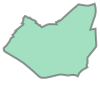

In [29]:
brgy_geo_for_city = brgy_geo.loc[brgy_geo["adm4_pcode"].str.startswith(city_initial_digits)].copy(deep = True)

city_geo = brgy_geo_for_city.union_all()
city_geo

# Read demand estimations

In [30]:
demand_b = pd.read_csv("05_outputs/demand_bike.csv").set_index("osmid")

demand_b.head()

,population_density,population_density_log,population_density_zscore,intersection_density,intersection_density_zscore,land_use_entropy,land_use_entropy_zscore,probability
osmid,,,,,,,,
321734921,33.012115,3.496875,0.137546,0.000158,-0.588223,0.872254,1.155065,0.000151
26365570,33.012115,3.496875,0.137546,0.000143,-0.817709,0.893496,1.249372,0.000146
8594662788,33.012115,3.496875,0.137546,0.000143,-0.817709,0.873744,1.161678,0.000144
6320023164,33.012115,3.496875,0.137546,0.000158,-0.588223,0.845268,1.035253,0.000149
25583974,96.976092,4.574464,1.441233,0.000173,-0.358737,0.372005,-1.065880,0.000144


In [31]:
demand_w = pd.read_csv("05_outputs/demand_walk.csv").set_index("osmid")

demand_w.head()

,population_density,population_density_log,population_density_zscore,intersection_density,intersection_density_zscore,land_use_entropy,land_use_entropy_zscore,probability
osmid,,,,,,,,
321734921,33.012115,3.496875,0.196258,0.000204,-0.591815,0.872254,1.177827,0.000147
26365570,33.012115,3.496875,0.196258,0.000178,-0.781036,0.893496,1.270674,0.000142
8594662788,33.012115,3.496875,0.196258,0.000183,-0.743191,0.873744,1.184337,0.000142
6320023164,33.012115,3.496875,0.196258,0.000204,-0.591815,0.845268,1.059869,0.000145
88776956,28.938799,3.365183,0.045862,0.000357,0.543510,0.594574,-0.035908,0.000161


In [32]:
b_node_probability = demand_b["probability"]
w_node_probability = demand_w["probability"]

# Read sampled nodes

In [33]:
# how to load

with open('05_outputs/sampled_nodes_for_curve_bike.pkl', 'rb') as f:
    b_list_nodes_sampled = pickle.load(f)

with open('05_outputs/sampled_nodes_for_curve_walk.pkl', 'rb') as f:
    w_list_nodes_sampled = pickle.load(f)

len(b_list_nodes_sampled), len(w_list_nodes_sampled)

(100, 100)

In [34]:
# f here means "filtered" but really it should mean "sampled"
Gb_nodes_f = Gb_nodes.loc[b_list_nodes_sampled].copy(deep = True)
Gw_nodes_f = Gw_nodes.loc[w_list_nodes_sampled].copy(deep = True)

In [35]:
Gb_nodes_f.shape, Gw_nodes_f.shape

((100, 93), (100, 94))

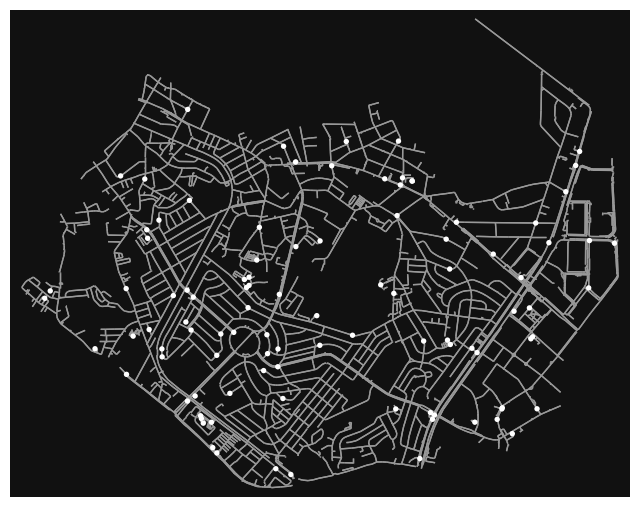

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [36]:
tg = ox.graph_from_gdfs(Gb_nodes_f, Gb_edges)
ox.plot_graph(tg)

## demand distribution for sampled nodes

In [37]:
def get_sample_node_probability_series(source, nodes_sampled):

    sample_node_to_probability = pd.Series({key: value for key, value in source.items() if key in nodes_sampled})
    total_prob = sum(sample_node_to_probability.values)
    sample_node_to_probability = sample_node_to_probability / total_prob

    return sample_node_to_probability

b_sample_node_probability = get_sample_node_probability_series(b_node_probability, b_list_nodes_sampled)
w_sample_node_probability = get_sample_node_probability_series(w_node_probability, w_list_nodes_sampled)

b_sample_node_probability.sum(), w_sample_node_probability.sum() # should be 1

(np.float64(0.9999999999999997), np.float64(1.0000000000000004))

# Read components and score data

In [38]:
folder = "04_outputs/" # note 01_outputs actually are generated after 02_outputs. So this is correct.

Gb_discomfort_components = pd.read_csv(folder + "bike_discomfort_components.csv").set_index(["u", "v", "key"], drop = True)
Gw_discomfort_components = pd.read_csv(folder + "walk_discomfort_components.csv").set_index(["u", "v", "key"], drop = True)

# Read heuristic: SLD

In [77]:
# how to load

with open('05_outputs/SLD_lookup_bike.pkl', 'rb') as f:
    distance_matrix_b = pickle.load(f)
    distance_matrix_b = distance_matrix_b.reindex(sorted(distance_matrix_b.columns), axis=1)
    distance_matrix_b = distance_matrix_b.sort_index()

with open('05_outputs/SLD_lookup_walk.pkl', 'rb') as f:
    distance_matrix_w = pickle.load(f)
    distance_matrix_w = distance_matrix_w.reindex(sorted(distance_matrix_w.columns), axis=1)
    distance_matrix_w = distance_matrix_w.sort_index()

In [78]:
distance_matrix_b.head()

osmid,12067613,12067619,12067627,21717860,21717864,21717865,21717866,24080775,24080860,25583811,...,12155422353,12164693625,12202093148,12202093150,12205481156,12205481157,12233670799,12233693922,12233693923,12233693924
osmid,,,,,,,,,,,,,,,,,,,,,
12067613,0.000000,179.847434,1717.671740,1131.359125,1769.590892,2057.777535,661.224362,1736.475198,274.070865,2560.304076,...,1939.237981,1603.346291,2684.607694,2688.261987,514.262000,504.853931,800.012196,847.977882,851.123783,854.920114
12067619,179.847434,0.000000,1538.557150,1114.038282,1747.125819,2024.918543,607.437492,1557.071341,97.055857,2429.627954,...,1759.446144,1426.079229,2519.134286,2522.771952,571.951263,562.060804,638.737819,702.906975,706.559664,710.848595
12067627,1717.671740,1538.557150,0.000000,1796.074370,2124.008712,2238.877684,1501.598613,37.729500,1449.478560,1578.133382,...,248.590035,421.865051,1164.953957,1167.986308,1911.048987,1903.798853,1080.390904,1163.697529,1165.815125,1167.633683
21717860,1131.359125,1114.038282,1796.074370,0.000000,638.231790,929.670707,521.129741,1830.820860,1145.011079,1806.947015,...,2042.153598,1947.374430,2287.778534,2291.335144,1645.598480,1636.160776,1527.277769,1652.218398,1657.122598,1662.488834
21717864,1769.590892,1747.125819,2124.008712,638.231790,0.000000,304.201259,1143.510080,2161.457520,1771.384451,1593.456075,...,2351.970388,2368.854734,2291.545256,2294.684854,2283.827913,2274.386816,2101.699324,2234.702855,2239.702515,2245.100805


In [71]:
len(list(distance_matrix_b.values))

6712

In [79]:
def SLD_meters_b_lookup(node1_osmid, node2_osmid):
    return distance_matrix_b.at[node1_osmid, node2_osmid]

def SLD_meters_w_lookup(node1_osmid, node2_osmid):
    return distance_matrix_w.at[node1_osmid, node2_osmid]

# CRS projections

In [42]:
import pyproj

from shapely.ops import transform

epsg4326 = pyproj.CRS('EPSG:4326')
epsg25391 = pyproj.CRS('EPSG:25391')

crs_projection = pyproj.Transformer.from_crs(epsg4326, epsg25391, always_xy=True).transform
crs_projection_reversed = pyproj.Transformer.from_crs(epsg25391, epsg4326, always_xy=True).transform

city_geo_transformed = transform(crs_projection, city_geo)

In [43]:
def transform_gdf(df, crs_projection, convert_xy = False):
    df_new = df.copy(deep = True)
    df_new["geometry"] = df["geometry"].apply(lambda x: transform(crs_projection, x))
    if convert_xy:
        df_new["x"] = df_new["geometry"].x
        df_new["y"] = df_new["geometry"].y

    return df_new

brgy_geo_for_city_transformed = transform_gdf(brgy_geo_for_city, crs_projection)

brgy_geo_for_city_transformed["geometry"].head()

0    POLYGON ((937560.04231 1618657.23203, 937567.4...
1    POLYGON ((934339.4248 1617985.615, 934347.1283...
2    POLYGON ((935997.30926 1617266.4851, 936157.49...
3    POLYGON ((935578.10485 1615585.00634, 935586.1...
4    POLYGON ((936697.08444 1615739.9868, 936737.05...
Name: geometry, dtype: geometry

In [44]:
Gb_nodes_transformed = transform_gdf(Gb_nodes, crs_projection, convert_xy=True)
Gw_nodes_transformed = transform_gdf(Gw_nodes, crs_projection, convert_xy=True)
Gb_edges_transformed = transform_gdf(Gb_edges, crs_projection)
Gw_edges_transformed = transform_gdf(Gw_edges, crs_projection)

# Generate objective function values

## Set beta for testing

In [45]:
test_beta = np.float64(1) # THIS SHOULD BE 1 WHEN RUNNING THE REST
f"{test_beta}"

'1.0'

In [46]:
from sklearn.preprocessing import MinMaxScaler

In [47]:
# now the minimum is 0 and the maximum can be any positive number

coef_scaler = MinMaxScaler(feature_range = (0, 1))

b_discomfort_coefs = pd.Series(
    test_beta * coef_scaler.fit_transform(Gb_discomfort_components[["score_weighted_by_main"]]).flatten(),
    index = Gb_discomfort_components.index
)

w_discomfort_coefs = pd.Series(
    test_beta * coef_scaler.fit_transform(Gw_discomfort_components[["score_weighted_by_main"]]).flatten(),
    index = Gw_discomfort_components.index
)

In [48]:
b_discomforts_weighted = b_discomfort_coefs * Gb_edges["length"]
w_discomforts_weighted = w_discomfort_coefs * Gw_edges["length"]

b_objective = Gb_edges["length"] + b_discomforts_weighted
w_objective = Gw_edges["length"] + w_discomforts_weighted

In [49]:
# CONCAT WITH FULL SET OF EDGES so it can be used in optimization
Gb_edges["OBJECTIVE"] = b_objective
Gw_edges["OBJECTIVE"] = w_objective

# also, for reference:
Gb_edges["DISCOMFORT_WEIGHTED_BY_BETA"] = b_discomforts_weighted
Gw_edges["DISCOMFORT_WEIGHTED_BY_BETA"] = w_discomforts_weighted

<Axes: >

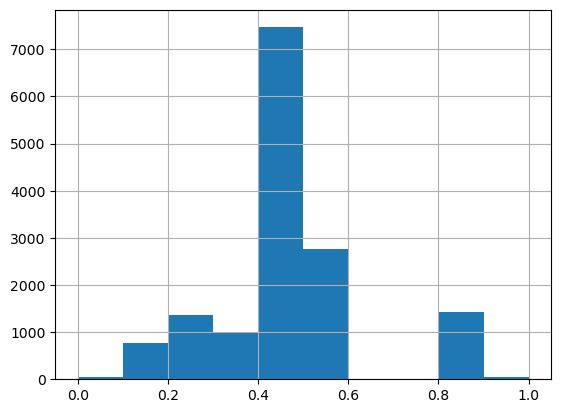

In [50]:
b_discomfort_coefs.hist()

<Axes: >

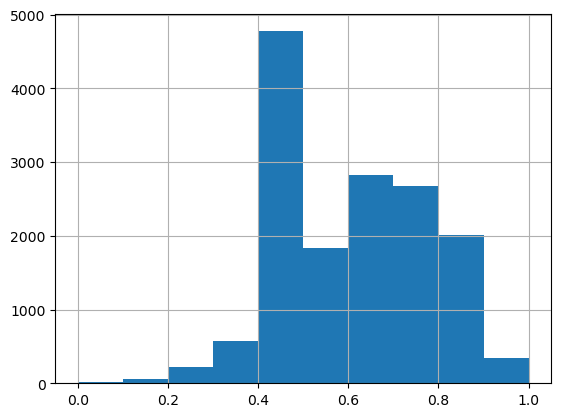

In [51]:
w_discomfort_coefs.hist()

<Axes: >

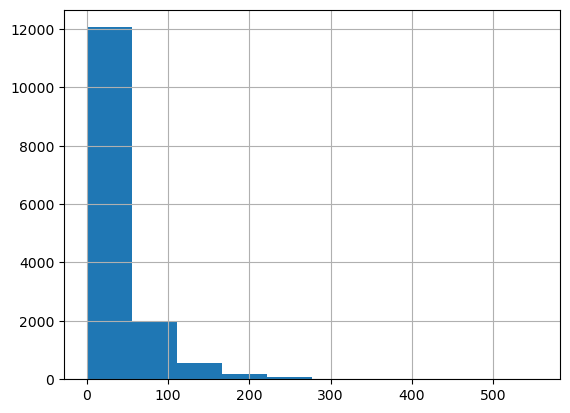

In [52]:
b_objective.hist()

## Construct actual graph to use (from geofabrik)

NOTE: this section should come after the section on scaling discomfort scores, since Gb_nodes and Gw_edges should contain the column of the objective function.

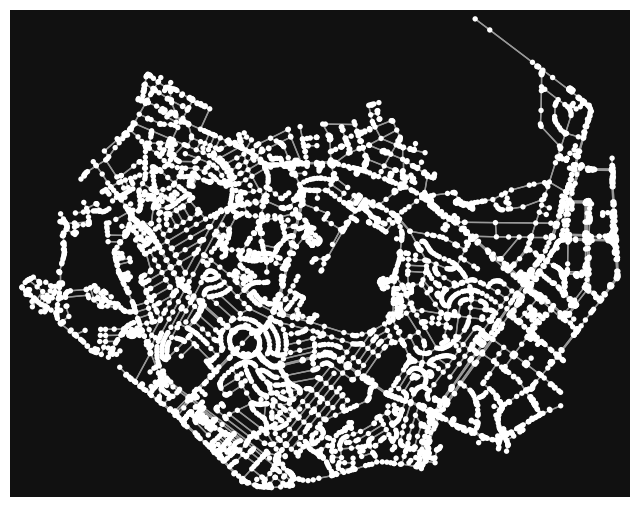

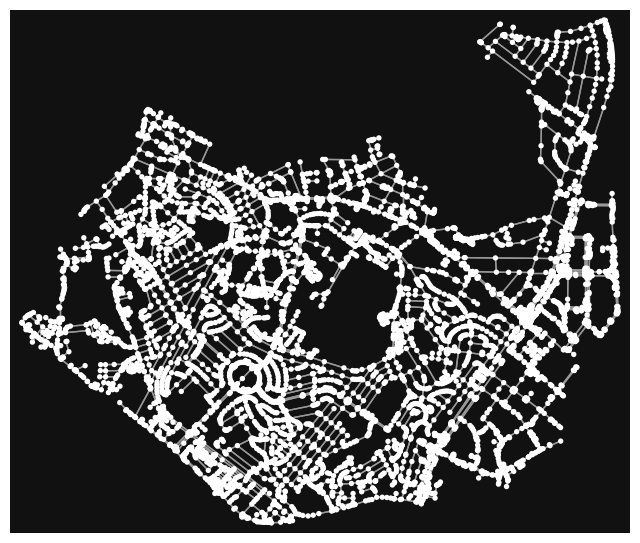

In [53]:
# it's called with_unweighted_discomfort because the DISCOMFORT_WEIGHTED_BY_BETA attribute of the edges should be on a scale of 0 to 1.
# this is so these graphs can be referenced by certain functions later on that require this behavior.
assert test_beta == 1

Gb_with_unweighted_discomfort = ox.graph_from_gdfs(Gb_nodes, Gb_edges)
Gw_with_unweighted_discomfort = ox.graph_from_gdfs(Gw_nodes, Gw_edges)

ox.plot_graph(Gb_with_unweighted_discomfort)
ox.plot_graph(Gw_with_unweighted_discomfort)
plt.show()

## Find lowest-objective paths


In [54]:
Gb_nodes_f.shape[0] ** 2, Gw_nodes_f.shape[0] ** 2

(10000, 10000)

In [81]:
calculate_lowest_objective_paths = False

if calculate_lowest_objective_paths:

    b_lowest_objective = dict()
    counter = 0
    print("Bike")
    for origin in Gb_nodes_f.index: #[:1]:
        for destination in Gb_nodes_f.index:
            counter += 1
            print(f"Solving pair: {counter}", end = "\r")
            # DEPRECATED: dont use a star in the final function, just use dijkstra.
            best_path = nx.astar_path(Gb_with_unweighted_discomfort, source = origin, target = destination, heuristic = SLD_meters_b_lookup, weight = "OBJECTIVE")
            b_lowest_objective[(origin, destination)] = best_path

    w_lowest_objective = dict()
    counter = 0
    print("\nWalk")
    for origin in Gw_nodes_f.index: #[:1]:
        for destination in Gw_nodes_f.index:
            counter += 1
            print(f"Solving pair: {counter}", end = "\r")
            # DEPRECATED: dont use a star in the final function, just use dijkstra.
            best_path = nx.astar_path(Gw_with_unweighted_discomfort, source = origin, target = destination, heuristic = SLD_meters_w_lookup, weight = "OBJECTIVE")
            w_lowest_objective[(origin, destination)] = best_path

In [57]:
test_beta_rounded = round(test_beta, 2)

In [58]:
if calculate_lowest_objective_paths:

    with open(f'08_outputs/bike_lowest_objective_paths-beta_{test_beta_rounded}.pkl', 'wb') as f:
        pickle.dump(b_lowest_objective, f)

    with open(f'08_outputs/walk_lowest_objective_paths-beta_{test_beta_rounded}.pkl', 'wb') as f:
        pickle.dump(w_lowest_objective, f)

In [37]:
# how to load

with open(f'08_outputs/bike_lowest_objective_paths-beta_{test_beta_rounded}.pkl', 'rb') as f:
    b_lowest_objective = pickle.load(f)

with open(f'08_outputs/walk_lowest_objective_paths-beta_{test_beta_rounded}.pkl', 'rb') as f:
    w_lowest_objective = pickle.load(f)

In [59]:
example_path_nodes = list(b_lowest_objective.values())[50]

In [60]:
example_path_nodes_gdf = Gb_nodes.loc[Gb_nodes.index.to_series().isin(example_path_nodes)]

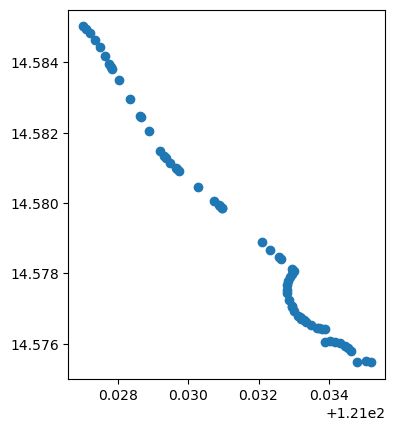

In [61]:
example_path_nodes_gdf.plot(aspect = 1)
plt.show()

In [62]:
(o, d), path_list = list(b_lowest_objective.items())[30]

(o, d), len(path_list)

((1467807116, 11722042176), 35)

In [63]:
Gb_edges.index.to_frame()["key"].value_counts() # key is always 0 pala

key
0    14878
Name: count, dtype: int64

In [64]:
print(Gb_with_unweighted_discomfort.get_edge_data(path_list[4], path_list[5], key = 0)["length"])

31.956


In [65]:
def calculate_path_cost(G, path_nodes, cost_attribute):
    path_cost = 0
    last_position = (len(path_nodes) - 1)
    raise_error = False
    for i, u in enumerate(path_nodes):
        if i < last_position:
            v = path_nodes[i + 1]
            try: 
                path_cost += G.get_edge_data(u, v, key = 0,
                                             default = G.get_edge_data(v, u, key = 0, default = None)
                                             )[cost_attribute]
            except:
                print("Step", i, ":", u, "and", v)
                raise_error = True
    if raise_error:
        raise ValueError("Some consecutive nodes had no edges between them")
    return path_cost

In [66]:
calculate_path_cost(Gb_with_unweighted_discomfort, path_list, cost_attribute = "length")

1032.9289999999999

In [ ]:
calculate_path_cost(Gb_with_unweighted_discomfort, path_list, cost_attribute = "DISCOMFORT_WEIGHTED_BY_BETA")

263.6918792820409

## Func: expected value of distance and discomfort

Beta is the coefficient multiplied by discomfort, and represents how sensitive a walker/biker is to discomfort.

In [68]:
def expected_values_from_optimal_paths(dict_lowest_objective_path, prob_dict, G_with_unweighted_discomfort, beta, sld_function, record_relative_values = False):
    """dict_lowest_objective: a dictionary mapping tuples of origin and destination nodes (represented by their integer osmid) to a list of integers representing the lowest-objective path.

prob_dict: a dict or Series mapping nodes to their corresponding probability of being an origin or destination. The sum of the values in prob_dict should be 1.
    
Return the expected distance and the expected discomfort."""
    
    ev_distance = 0
    ev_discomfort_unweighted = 0 # based on the original discomfort values, which range from 0 to 1
    ev_discomfort_weighted = 0 # based on the discomfort values weighted by beta
    
    total_actual_probability = sum([prob_dict[o] * prob_dict[d] for (o, d) in dict_lowest_objective_path.keys() if (o != d)])

    for od_pair, path_list in dict_lowest_objective_path.items():
        o, d = od_pair
        if o != d: # do not consider paths of zero length; no one cares about them
            joint_prob = prob_dict[o] * prob_dict[d] / total_actual_probability
            
            dist_travelled_raw = calculate_path_cost(G_with_unweighted_discomfort, path_list, "length")
            distance_term = joint_prob * dist_travelled_raw
            discomfort_term_unweighted = joint_prob * calculate_path_cost(G_with_unweighted_discomfort, path_list, "DISCOMFORT_WEIGHTED_BY_BETA")
            # IMPORTANT: yes, unweighted terms should come from the calculation that uses "DISCOMFORT_WEIGHTED_BY_BETA". This is because the provided graph is assumed to provide values weighted by beta=1.
            discomfort_term_weighted = discomfort_term_unweighted * beta # note this only matters for how the optimization worked but doesnt matter at all for interpretation

            if record_relative_values:
                euclidean_distance = sld_function(o, d)
                
                discomfort_term_unweighted = discomfort_term_unweighted / dist_travelled_raw
                discomfort_term_weighted = discomfort_term_weighted / dist_travelled_raw
                distance_term = distance_term / euclidean_distance


            ev_distance += distance_term
            ev_discomfort_weighted += discomfort_term_weighted # note this only matters for how the optimization worked but doesnt matter at all for interpretation
            ev_discomfort_unweighted += discomfort_term_unweighted

    return ev_distance, ev_discomfort_weighted, ev_discomfort_unweighted # unweighted comes last in output! it matters

In [82]:
expected_values_from_optimal_paths(b_lowest_objective, b_sample_node_probability, Gb_with_unweighted_discomfort, beta = test_beta, sld_function = SLD_meters_b_lookup, record_relative_values = True)

(np.float64(1.4976647790625863),
 np.float64(0.3145930158628893),
 np.float64(0.3145930158628893))

# Compute the entire curve

In [83]:
# to avoid taking too much memory
Gb_reduced_edges = Gb_edges[["length", "geometry"]].copy(deep = True)
Gw_reduced_edges = Gw_edges[["length", "geometry"]].copy(deep = True)

Gb_reduced_nodes = Gb_nodes[["x", "y"]].copy(deep = True)
Gw_reduced_nodes = Gw_nodes[["x", "y"]].copy(deep = True)

In [84]:
# test
coef_scaler = MinMaxScaler(feature_range = (0, 4))
pd.Series(
        coef_scaler.fit_transform(Gb_discomfort_components[["score_weighted_by_main"]]).flatten(),
        index = Gb_discomfort_components.index
    )

u            v            key
321734921    26365570     0      1.017891
             8594662788   0      1.737710
             6320023164   0      1.017891
26365570     321734921    0      1.017891
8594662788   5429550720   0      1.737710
                                   ...   
12101126573  12101126574  0      3.280181
12101126572  12101126567  0      3.280181
             12101126573  0      3.280181
6773491495   248009368    0      0.606566
             6375475926   0      0.606566
Length: 14878, dtype: float64

<Axes: >

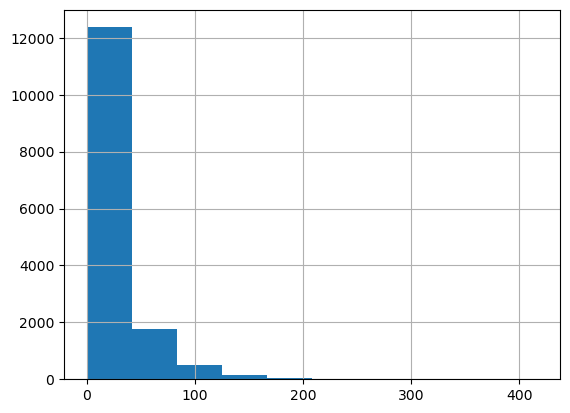

In [85]:
Gb_edges["length"].hist()

In [86]:
def expected_values_given_beta(beta, Gb_reduced_edge_df, Gw_reduced_edge_df, Gb_reduced_node_df, Gw_reduced_node_df, Gb_nodes_f, Gw_nodes_f,
                            #    Gb_with_unweighted_discomfort, Gw_with_unweighted_discomfort,
                               Gb_discomfort_components, Gw_discomfort_components,
                               b_sample_node_probability_dict, w_sample_node_probability_dict,
                               out_folder = "08_outputs", prefix = "", record_relative_values = False):
    """Note this function writes files to `out_folder` which should be a string with the folder name, not ending with a slash. `prefix` lets you prepend a string to the file names."""
    coef_scaler = MinMaxScaler(feature_range = (0, 1))

    beta = np.float64(beta)

    b_discomfort_coefs = pd.Series(
        beta * coef_scaler.fit_transform(Gb_discomfort_components[["score_weighted_by_main"]]).flatten(),
        index = Gb_discomfort_components.index
    )

    w_discomfort_coefs = pd.Series(
        beta * coef_scaler.fit_transform(Gw_discomfort_components[["score_weighted_by_main"]]).flatten(),
        index = Gw_discomfort_components.index
    )

    Gb_reduced_edges = Gb_reduced_edge_df.copy(deep = True)
    Gw_reduced_edges = Gw_reduced_edge_df.copy(deep = True)

    b_discomforts_weighted = b_discomfort_coefs * Gb_reduced_edges["length"]
    w_discomforts_weighted = w_discomfort_coefs * Gw_reduced_edges["length"]

    b_objective = Gb_reduced_edges["length"] + b_discomforts_weighted
    w_objective = Gw_reduced_edges["length"] + w_discomforts_weighted

    # # REMOVED. the way i coded it, it should never be negative in the first place.
    # b_objective = b_objective.mask(b_objective < 0, 0)
    # w_objective = w_objective.mask(w_objective < 0, 0)

    # remove existing columns with this name
    Gb_reduced_edges = Gb_reduced_edges.drop(["OBJECTIVE", "DISCOMFORT_WEIGHTED_BY_BETA"], axis = 1, errors = "ignore")
    Gw_reduced_edges = Gw_reduced_edges.drop(["OBJECTIVE", "DISCOMFORT_WEIGHTED_BY_BETA"], axis = 1, errors = "ignore")

    # ADD TO FULL SET OF EDGES so it can be used in optimization
    Gb_reduced_edges["OBJECTIVE"] = b_objective
    Gw_reduced_edges["OBJECTIVE"] = w_objective

    # also, for reference:
    Gb_reduced_edges["DISCOMFORT_WEIGHTED_BY_BETA"] = b_discomforts_weighted
    Gw_reduced_edges["DISCOMFORT_WEIGHTED_BY_BETA"] = w_discomforts_weighted

    Gb = ox.graph_from_gdfs(Gb_reduced_node_df, Gb_reduced_edges)
    Gw = ox.graph_from_gdfs(Gw_reduced_node_df, Gw_reduced_edges)

    # # Retain only the subgraph of the largest connected component
    # Gb = Gb.subgraph(max(nx.weakly_connected_components(Gb), key = len)).copy()
    # Gw = Gw.subgraph(max(nx.weakly_connected_components(Gw), key = len)).copy()

    b_lowest_objective = dict()
    counter = 0
    print("Bike")
    for origin in Gb_nodes_f.index: #[:1]:
        for destination in Gb_nodes_f.index:
            counter += 1
            print(f"Solving pair: {counter}", end = "\r")
            
            # best_path = nx.astar_path(Gb, source = origin, target = destination, heuristic = SLD_meters_b_lookup, weight = "OBJECTIVE")
            best_path = nx.shortest_path(Gb, source = origin, target = destination, weight = "OBJECTIVE")
            
            b_lowest_objective[(origin, destination)] = best_path
    
    w_lowest_objective = dict()
    counter = 0
    print("\nWalk")
    for origin in Gw_nodes_f.index: #[:1]:
        for destination in Gw_nodes_f.index:
            counter += 1
            print(f"Solving pair: {counter}", end = "\r")

            # best_path = nx.astar_path(Gw, source = origin, target = destination, heuristic = SLD_meters_w_lookup, weight = "OBJECTIVE")
            best_path = nx.shortest_path(Gw, source = origin, target = destination, weight = "OBJECTIVE")

            w_lowest_objective[(origin, destination)] = best_path

    beta_rounded = round(beta, 2)

    actual_prefix = f"{prefix}_" if len(prefix) > 0 else ""

    with open(f'{out_folder}/{actual_prefix}bike_lowest_objective_paths-beta_{beta_rounded}.pkl', 'wb') as f:
        pickle.dump(b_lowest_objective, f)

    with open(f'{out_folder}/{actual_prefix}walk_lowest_objective_paths-beta_{beta_rounded}.pkl', 'wb') as f:
        pickle.dump(w_lowest_objective, f)

    result = {
        "bike": expected_values_from_optimal_paths(b_lowest_objective, b_sample_node_probability_dict, Gb_with_unweighted_discomfort, beta = beta, sld_function=SLD_meters_b, record_relative_values = record_relative_values),
        "walk": expected_values_from_optimal_paths(w_lowest_objective, w_sample_node_probability_dict, Gw_with_unweighted_discomfort, beta = beta, sld_function=SLD_meters_w, record_relative_values = record_relative_values)
    }

    return result

In [88]:
compute_for_many_beta = True

if compute_for_many_beta:

    for beta in [
        0,
        0.5,
        1,
        1.5,
        2,
        2.5,
        3,
    ]:
        print(f"\n\nBeta = {beta}")
        result = expected_values_given_beta(beta, Gb_reduced_edges, Gw_reduced_edges, Gb_reduced_nodes, Gw_reduced_nodes, Gb_nodes_f, Gw_nodes_f, Gb_discomfort_components, Gw_discomfort_components, b_sample_node_probability, w_sample_node_probability, out_folder = "08_outputs", prefix = "", record_relative_values=True)
        print("\n")
        print(result)



Beta = 0
Bike


KeyboardInterrupt: 

In [65]:
# if compute_for_many_beta:

#     # 0: distance
#     # 1: weighted discomfort
#     # 2: unweighted discomfort (we need this for comparison)
#     bike_evs = pd.DataFrame([(key, d["bike"][0], d["bike"][2]) for key, d in tracker.items()])
#     bike_evs.columns = ["beta", "distance", "discomfort"]

#     bike_evs

# Mandaluyong curves

In [66]:
import os
os.listdir("08_outputs")

['per_brgy_DICT_sampled_nodes_for_curve_bike.pkl',
 'walk_lowest_objective_paths-beta_1.5.pkl',
 '.DS_Store',
 'walk_lowest_objective_paths-beta_1.0.pkl',
 'walk_lowest_objective_paths-beta_3.0.pkl',
 'ignore',
 'walk_lowest_objective_paths-beta_0.5.pkl',
 'walk_lowest_objective_paths-beta_2.5.pkl',
 'walk_lowest_objective_paths-beta_2.0.pkl',
 'walk_lowest_objective_paths-beta_0.0.pkl',
 'bike_lowest_objective_paths-beta_0.0.pkl',
 'bike_lowest_objective_paths-beta_2.0.pkl',
 'bike_lowest_objective_paths-beta_2.5.pkl',
 'bike_lowest_objective_paths-beta_0.5.pkl',
 'bike_lowest_objective_paths-beta_3.0.pkl',
 'bike_lowest_objective_paths-beta_1.0.pkl',
 'per_brgy_DICT_sampled_nodes_for_curve_walk.pkl',
 'bike_lowest_objective_paths-beta_1.5.pkl',
 'per_barangay']

In [67]:
bike_tracker = {}
walk_tracker = {}

for filename in os.listdir("08_outputs"):
    if filename.startswith("bike_lowest_objective") or filename.startswith("walk_lowest_objective"):
        # try:
            current_mode = filename[:4] # bike or walk
            current_beta = np.float64(filename[33:][:-4])
            with open(f"08_outputs/{filename}", "rb") as f:
                contents = pickle.load(f)
            if current_mode == "bike":
                evs = expected_values_from_optimal_paths(contents, b_node_probability, Gb_with_unweighted_discomfort, beta = current_beta, sld_function = SLD_meters_b, record_relative_values=True)
                bike_tracker[current_beta] = evs
            elif current_mode == "walk":
                evs = expected_values_from_optimal_paths(contents, w_node_probability, Gw_with_unweighted_discomfort, beta = current_beta, sld_function = SLD_meters_w, record_relative_values=True)
                walk_tracker[current_beta] = evs
        # except:
        #     pass

In [68]:
n, e = ox.graph_to_gdfs(Gw_with_unweighted_discomfort)

# this is here to remind me that unweighted discomfort is less than or equal to length
e["DISCOMFORT_WEIGHTED_BY_BETA"], e["length"]

(u           v           key
 321734921   26365570    0      20.339786
             8594662788  0      20.145563
             6320023164  0      18.513327
 26365570    321734921   0      20.339786
 8594662788  5429550720  0      21.020679
                                  ...    
 6551939560  747050329   0      14.726726
 8317572222  8317572223  0       2.555228
             8317572224  0       3.116058
 8317572223  8317572225  0       8.346422
             8317572222  0       2.555228
 Name: DISCOMFORT_WEIGHTED_BY_BETA, Length: 15332, dtype: float64,
 u           v           key
 321734921   26365570    0      28.620
             8594662788  0      30.410
             6320023164  0      26.050
 26365570    321734921   0      28.620
 8594662788  5429550720  0      31.731
                                 ...  
 6551939560  747050329   0      39.726
 8317572222  8317572223  0       3.367
             8317572224  0       4.106
 8317572223  8317572225  0      10.998
             8317572222

In [69]:
bike_evs = pd.DataFrame([(key, d[0], d[2]) for key, d in bike_tracker.items()])
bike_evs.columns = ["beta", "distance", "discomfort"]
bike_evs = bike_evs.sort_values("beta").reset_index(drop = True)

bike_evs

,beta,distance,discomfort
0,0.0,1.445102,0.355242
1,0.5,1.453775,0.322547
2,1.0,1.467364,0.305907
3,1.5,1.471933,0.302379
4,2.0,1.478152,0.298903
5,2.5,1.484784,0.295667
6,3.0,1.489867,0.293243


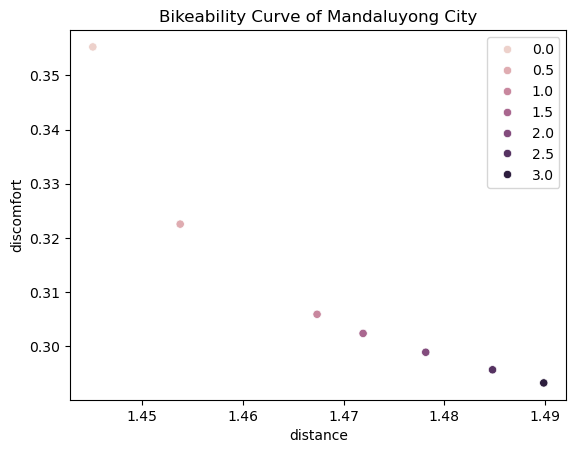

In [70]:
sns.scatterplot(
    bike_evs,
    x = "distance", # note this should be labelled RELATIVE distance and RELATIVE discomfort
    y = "discomfort",
    hue = "beta"
)
plt.legend()
plt.title("Bikeability Curve of Mandaluyong City")
plt.show()

In [71]:
walk_evs = pd.DataFrame([(key, d[0], d[2]) for key, d in walk_tracker.items()])
walk_evs.columns = ["beta", "distance", "discomfort"]
walk_evs = walk_evs.sort_values("beta").reset_index(drop = True)

walk_evs

,beta,distance,discomfort
0,0.0,1.435798,0.517211
1,0.5,1.443938,0.503240
2,1.0,1.449096,0.500692
3,1.5,1.454753,0.498874
4,2.0,1.461914,0.499775
5,2.5,1.466456,0.499321
6,3.0,1.467397,0.499647


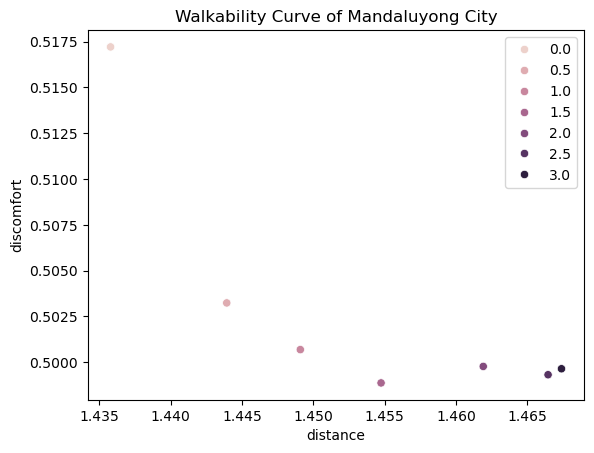

In [72]:
sns.scatterplot(
    walk_evs,
    x = "distance",
    y = "discomfort",
    hue = "beta"
)
plt.title("Walkability Curve of Mandaluyong City")
plt.legend()
plt.show()

# Per-barangay curves

In [73]:
brgy_geo[["adm4_en", "adm4_pcode"]].value_counts()

adm4_en               adm4_pcode 
Addition Hills        PH137401001    1
Mabini-J. Rizal       PH137401015    1
Vergara               PH137401026    1
San Jose              PH137401025    1
Poblacion             PH137401024    1
Pleasant Hills        PH137401023    1
Plainview             PH137401022    1
Pag-asa               PH137401021    1
Old Zañiga            PH137401020    1
New Zañiga            PH137401019    1
Namayan               PH137401018    1
Mauway                PH137401017    1
Malamig               PH137401016    1
Hulo                  PH137401014    1
Bagong Silang         PH137401002    1
Highway Hills         PH137401013    1
Harapin Ang Bukas     PH137401012    1
Hagdang Bato Libis    PH137401011    1
Hagdang Bato Itaas    PH137401010    1
Daang Bakal           PH137401009    1
Burol                 PH137401007    1
Buayang Bato          PH137401008    1
Barangka Itaas        PH137401006    1
Barangka Ilaya        PH137401005    1
Barangka Ibaba        PH137401

In [74]:
brgy_pcodes = brgy_geo["adm4_pcode"].unique()
brgy_pcodes

array(['PH137401027', 'PH137401009', 'PH137401023', 'PH137401004',
       'PH137401005', 'PH137401021', 'PH137401003', 'PH137401016',
       'PH137401011', 'PH137401001', 'PH137401008', 'PH137401013',
       'PH137401012', 'PH137401026', 'PH137401017', 'PH137401006',
       'PH137401002', 'PH137401010', 'PH137401025', 'PH137401014',
       'PH137401007', 'PH137401020', 'PH137401015', 'PH137401024',
       'PH137401019', 'PH137401018', 'PH137401022'], dtype=object)

In [75]:
brgy_pcode_to_name = {row["adm4_pcode"]: row["adm4_en"] for index, row in brgy_geo[["adm4_en", "adm4_pcode"]].value_counts().reset_index(drop = False).iterrows()}

brgy_pcode_to_name

{'PH137401001': 'Addition Hills',
 'PH137401015': 'Mabini-J. Rizal',
 'PH137401026': 'Vergara',
 'PH137401025': 'San Jose',
 'PH137401024': 'Poblacion',
 'PH137401023': 'Pleasant Hills',
 'PH137401022': 'Plainview',
 'PH137401021': 'Pag-asa',
 'PH137401020': 'Old Zañiga',
 'PH137401019': 'New Zañiga',
 'PH137401018': 'Namayan',
 'PH137401017': 'Mauway',
 'PH137401016': 'Malamig',
 'PH137401014': 'Hulo',
 'PH137401002': 'Bagong Silang',
 'PH137401013': 'Highway Hills',
 'PH137401012': 'Harapin Ang Bukas',
 'PH137401011': 'Hagdang Bato Libis',
 'PH137401010': 'Hagdang Bato Itaas',
 'PH137401009': 'Daang Bakal',
 'PH137401007': 'Burol',
 'PH137401008': 'Buayang Bato',
 'PH137401006': 'Barangka Itaas',
 'PH137401005': 'Barangka Ilaya',
 'PH137401004': 'Barangka Ibaba',
 'PH137401003': 'Barangka Drive',
 'PH137401027': 'Wack-wack Greenhills'}

## Construct graphs for this

In [76]:
Gb_with_unweighted_discomfort_transformed = ox.graph_from_gdfs(Gb_nodes_transformed, Gb_edges_transformed)
Gw_with_unweighted_discomfort_transformed = ox.graph_from_gdfs(Gw_nodes_transformed, Gw_edges_transformed)

## Sample nodes from each barangay

## filter conditions

In [77]:
def mask_exclude_nodes(nodes_gdf):

    exclude_notnull = [
        f"TAG_{s}" for s in
        ("crossing", "crossing:markings", "crossing:signals", "crossing:island", "traffic_signals", "traffic_signals:sound", "kerb", "crossing_ref", "traffic_calming", "traffic_calming:direction", "parking", "traffic_signals:vibration", "access:conditional")
        if s in nodes_gdf.columns
    ]

    false_mask = pd.Series([False] * nodes_gdf.shape[0], index = nodes_gdf.index)

    mask1 = nodes_gdf["TAG_access"].isin(["private", "no", "customers", "delivery"]) if "TAG_access" in nodes_gdf.columns else false_mask
    mask2 = nodes_gdf["TAG_amenity"].isin(["parking_entrance", "parking"]) if "TAG_amenity" in nodes_gdf.columns else false_mask
    mask3 = nodes_gdf["TAG_highway"].isin(["crossing", "traffic_signals", "milestone", "stop", "give_way", "motor_junction", "elevator", "turning_circle"]) if "TAG_highway" in nodes_gdf.columns else false_mask

    mask = (
        (nodes_gdf[exclude_notnull].notnull().sum(axis = 1) > 0)
        | mask1
        | mask2
        | mask3
    )

    return mask

In [78]:
## sample nodes from each barangay
## note this uses the CRS-transformed dataframes so that accurate SLD can be obtained

n_sample_brgy = 10

b_dct_identifiers = {}
w_dct_identifiers = {}

b_dct_sampled_nodes_dfs = {}
w_dct_sampled_nodes_dfs = {}

b_dct_reduced_dfs = {}
w_dct_reduced_dfs = {}

for index, brgy_row in brgy_geo_for_city_transformed.iterrows():

    brgy_code = brgy_row["adm4_pcode"]
    geo = brgy_row["geometry"]

    # bike

    # # make a graph for just the barangay
    b_brgy_graph = ox.truncate.truncate_graph_polygon(Gb_with_unweighted_discomfort_transformed, geo, truncate_by_edge=True) # retain nodes outside boundary polygon if at least one of node’s neighbors is within the polygon
    b_brgy_nodes, b_brgy_edges = ox.graph_to_gdfs(b_brgy_graph)
    b_dct_reduced_dfs[brgy_code] = (
        b_brgy_nodes[["x", "y", "geometry"]].copy(deep = True),
        b_brgy_edges[["length", "geometry"]].copy(deep = True)
    )

    ### Deprecated way of sampling
    # Gb_nodes_f_brgy = Gb_nodes_transformed.loc[
    #     (~mask_exclude_nodes(Gb_nodes_transformed))
    #     & Gb_nodes_transformed.covered_by(geo)
    # ].sample(n_sample_brgy, replace = False, random_state = 0)

    Gb_nodes_f_brgy = b_brgy_nodes.loc[(~mask_exclude_nodes(b_brgy_nodes))].sample(n_sample_brgy, replace = False, random_state=42)
    b_dct_identifiers[brgy_code] = Gb_nodes_f_brgy.index.tolist()
    b_dct_sampled_nodes_dfs[brgy_code] = Gb_nodes_f_brgy

    # walk

    # # make a graph for just the barangay
    w_brgy_graph = ox.truncate.truncate_graph_polygon(Gw_with_unweighted_discomfort_transformed, geo, truncate_by_edge=True) # retain nodes outside boundary polygon if at least one of node’s neighbors is within the polygon
    w_brgy_nodes, w_brgy_edges = ox.graph_to_gdfs(w_brgy_graph)
    w_dct_reduced_dfs[brgy_code] = (
        w_brgy_nodes[["x", "y", "geometry"]].copy(deep = True),
        w_brgy_edges[["length", "geometry"]].copy(deep = True)
    )

    Gw_nodes_f_brgy = w_brgy_nodes.loc[(~mask_exclude_nodes(w_brgy_nodes))].sample(n_sample_brgy, replace = False, random_state=42)
    w_dct_identifiers[brgy_code] = Gw_nodes_f_brgy.index.tolist()
    w_dct_sampled_nodes_dfs[brgy_code] = Gw_nodes_f_brgy

with open("08_outputs/per_brgy_DICT_sampled_nodes_for_curve_bike.pkl", "wb") as f:
    pickle.dump(b_dct_identifiers, f)

with open("08_outputs/per_brgy_DICT_sampled_nodes_for_curve_walk.pkl", "wb") as f:
    pickle.dump(w_dct_identifiers, f)

In [79]:
### how to load

load_sampled_nodes_per_brgy = False

if load_sampled_nodes_per_brgy:

    with open('08_outputs/per_brgy_DICT_sampled_nodes_for_curve_bike.pkl', 'rb') as f:
        b_sampled_nodes_per_brgy = pickle.load(f)

    with open('08_outputs/per_brgy_DICT_sampled_nodes_for_curve_walk.pkl', 'rb') as f:
        w_sampled_nodes_per_brgy = pickle.load(f)

### check sampled nodes

In [80]:
# b_check_sample_nodes_brgy = ox.graph_from_gdfs(Gb_nodes_f_brgy, Gb_edges_transformed)
# w_check_sample_nodes_brgy = ox.graph_from_gdfs(Gw_nodes_f_brgy, Gw_edges_transformed)

# ox.plot_graph(b_check_sample_nodes_brgy)
# ox.plot_graph(w_check_sample_nodes_brgy)
# plt.show()

## Compute

In [81]:
compute_per_barangay = True

if compute_per_barangay:

    tracker = {}

    for i, brgy_code in enumerate(brgy_pcodes):

        brgy_name = brgy_pcode_to_name[brgy_code]
        
        print(f"\n\n------\n{i+1}-th barangay: {brgy_name}")

        Gb_nodes_reduced_brgy, Gb_edges_reduced_brgy = b_dct_reduced_dfs[brgy_code]
        Gw_nodes_reduced_brgy, Gw_edges_reduced_brgy = w_dct_reduced_dfs[brgy_code]

        for beta in [
            0,
            0.5,
            1,
            1.5,
            2,
            2.5,
            3,
        ]:
            print(f"\n\nBeta = {beta}")
            tracker[(brgy_code, beta)] = expected_values_given_beta(
                beta,
                Gb_reduced_edge_df = Gb_edges_reduced_brgy,
                Gw_reduced_edge_df = Gw_edges_reduced_brgy,
                Gb_reduced_node_df = Gb_nodes_reduced_brgy,
                Gw_reduced_node_df = Gw_nodes_reduced_brgy,
                Gb_nodes_f = b_dct_sampled_nodes_dfs[brgy_code],
                Gw_nodes_f = w_dct_sampled_nodes_dfs[brgy_code],
                Gb_discomfort_components = Gb_discomfort_components.loc[b_dct_identifiers[brgy_code]],
                Gw_discomfort_components = Gw_discomfort_components.loc[w_dct_identifiers[brgy_code]],
                b_sample_node_probability_dict = get_sample_node_probability_series(b_node_probability, b_dct_identifiers[brgy_code]),
                w_sample_node_probability_dict = get_sample_node_probability_series(w_node_probability, w_dct_identifiers[brgy_code]),
                out_folder="08_outputs/per_barangay",
                prefix = f"{brgy_code}_{brgy_name[:5]}" # include the first 5 letters of the barangay name just for reference
            )
            print("\n")
            print(tracker[(brgy_code, beta)])



------
1-th barangay: Wack-wack Greenhills


Beta = 0
Bike
Solving pair: 100
Walk
Solving pair: 100

{'bike': (np.float64(1122.0857359541226), np.float64(0.0), np.float64(698.7153452114967)), 'walk': (np.float64(2083.855508647035), np.float64(0.0), np.float64(1200.8688865880242))}


Beta = 0.5
Bike
Solving pair: 100
Walk
Solving pair: 100

{'bike': (np.float64(1122.0857359541226), np.float64(349.35767260574835), np.float64(698.7153452114967)), 'walk': (np.float64(2083.855508647035), np.float64(600.4344432940121), np.float64(1200.8688865880242))}


Beta = 1
Bike
Solving pair: 100
Walk
Solving pair: 100

{'bike': (np.float64(1122.0857359541226), np.float64(698.7153452114967), np.float64(698.7153452114967)), 'walk': (np.float64(2083.855508647035), np.float64(1200.8688865880242), np.float64(1200.8688865880242))}


Beta = 1.5
Bike
Solving pair: 100
Walk
Solving pair: 100

{'bike': (np.float64(1122.0857359541226), np.float64(1048.0730178172444), np.float64(698.7153452114967)), 'walk': (np.